In [34]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys
import h5py
os.environ["GDAL_DATA"] = '/Users/ccroberts/opt/anaconda3/envs/fresh/share/gdal' # need to specify to make gdal work
os.environ["PROJ_LIB"] = '/Users/ccroberts/opt/anaconda3/envs/fresh/share/proj' # need to specify to make pyproj work
os.environ["PROJ_DATA"] = '/Users/ccroberts/opt/anaconda3/envs/fresh/share/proj' # need to specify to make pyproj work

import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import cm 
import matplotlib
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
import geopandas as gpd
import shapely
from shapely import box, LineString, Point
from ipyleaflet import Map, basemaps, Polygon, Polyline, GeoData, LayersControl
from datetime import datetime
from datetime import timedelta
from datetime import timezone
#from dateutil.relativedelta import relativedelt
from rasterio import warp
from rasterio.crs import CRS
import shutil
import time
import traceback

import pyTMD

if 'cmcrameri' not in sys.modules:
    ! pip3 install cmcrameri >/dev/null
if 'contextily' not in sys.modules:
    ! pip3 install contextily >/dev/null
import cmcrameri.cm as cmc
import contextily as cx

'''
try:
    from ed.edcreds import getedcreds
except:
    print('No earthdata credentials found.')
    print('To set up, rename the folder "ed_example" to "ed".')
    print('Then, add your earthdata credentials to "ed/edcreds.py".')
'''

from utils.nsidc import download_is2
#from utils.S2 import plotS2cloudfree, add_inset, convert_time_to_string
from utils.utilities import is2dt2str

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Specify the base parameters

We do this using the package `contextily`, which provides basemaps for plotting in matplotlib. Here we use ESRI's WordImagery basemap. 

In [35]:
'''

Terrible process
you have to export polygons as 4326 from QGIS
Then you can force import them as 4326 and convert to 3031

because NSIDC needs 4326 polygons
'''

'\n\nTerrible process\nyou have to export polygons as 4326 from QGIS\nThen you can force import them as 4326 and convert to 3031\n\nbecause NSIDC needs 4326 polygons\n'

In [63]:
basin = 'Cp-D'
region='tide_test_2'
track = 1352 #totten
track = 727 #test
track = 841 # tide_test
track=1047 #tide_test_2
#track=537 #chugunov

In [66]:
#shape for the subsetting
shape = f'shapes/{basin}_{region}.shp'
#shape for the outline of the pinning point
pts = f'shapes/{basin}_{region}_pp.shp'
plot_dir = 'plots'
crs_antarctica = 'EPSG:3031'
crs_latlon = 'EPSG:4326'
short_name = 'ATL11'
output_dir = f'data/is2/{short_name}_{shape[:shape.rfind('.')].split('/')[-1]}'
gdf = gpd.read_file(shape).set_crs(crs_latlon, allow_override=True).to_crs(crs_antarctica)
pp_gdf = gpd.read_file(pts).set_crs(crs_latlon, allow_override=True).to_crs(crs_antarctica)

<Axes: >

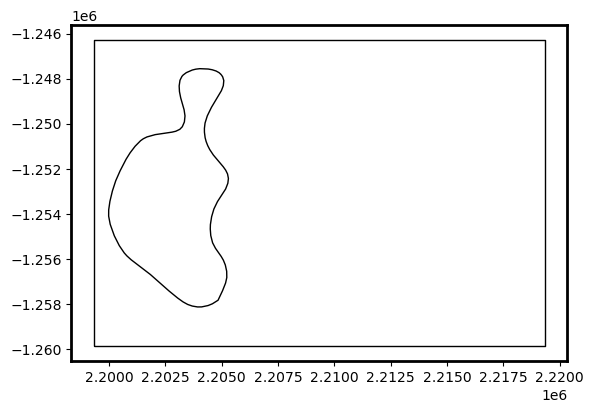

In [67]:
fig1, ax1 = plt.subplots()
pp_gdf.plot(ax=ax1, color='None', edgecolor='black')
gdf.plot(ax=ax1, color='None', edgecolor='black')

# define a bunch of functions

In [83]:
def download_data():
    uid,pw,eml = getedcreds()
    output_dir = f'data/is2/{short_name}_{shape[:shape.rfind('.')].split('/')[-1]}'
    download_is2(short_name='ATL11', uid=uid, pwd=pw, email=eml, output_dir=output_dir, shape=shape, shape_subset=shape)
    print('saved files to %s' % output_dir)
    return output_dir

def get_file_info():
    search_for = '%s_' % short_name
    search_in = output_dir + '/'
    filelist = [search_in+f for f in os.listdir(search_in) \
                if os.path.isfile(os.path.join(search_in, f)) & (search_for in f) & ('.h5' in f)]
    filelist.sort()
    print('There are %i files.' % len(filelist))
    
    dirdict = dict([(x,'ascending') for x in [1,2,3,12,13,14]] + \
                   [(x,'descending') for x in [5,6,7,8,9,10]] + \
                   [(x,'turning') for x in [4,11]])
    df_files = pd.DataFrame({'filename': filelist})
    df_files['granule_id'] = df_files.apply(lambda x: x.filename[x.filename.rfind(search_for):], axis=1)
    df_files['tides_filename'] = df_files.apply(lambda x: f'{output_dir}/tides/ATL11_CATS2008-v2023_TIDES_{x.granule_id[6:]}', axis=1)
    df_files['track'] = df_files.apply(lambda x: int(x.granule_id[6:10]), axis=1)
    df_files['region'] = df_files.apply(lambda x: int(x.granule_id[10:12]), axis=1)
    df_files['direction'] = df_files.apply(lambda x: dirdict[x.region], axis=1)
    df_files['cycles'] = df_files.apply(lambda x: '%s-%s' % (x.granule_id[13:15],x.granule_id[15:17]), axis=1)
    df_files['version'] = df_files.apply(lambda x: int(x.granule_id[18:21]), axis=1)
    df_files['release'] = df_files.apply(lambda x: int(x.granule_id[22:24]), axis=1)
    return df_files

def getedcreds():

    # change your credentials here, do not push them to github! 
    uid = 'ccroberts'
    pwd = 'your_earthdata_password'
    email = 'ccroberts@ucsd.edu'

    # to print a message if they haven't been changed
    if uid == '<your_nasa_earthdata_user_id>':
        print('\n WARNING: YOU NEED TO SET UP YOUR NASA EARTHDATA CREDENTIALS TO DOWNLOAD ICESAT-2 DATA!\n')
        print('  update the info in ed/edcreds.py :\n')
        print("  def getedcreds():")
        print("    # change your credentials here, do not push them to github!")
        print("    uid = '<your_nasa_earthdata_user_id>'")
        print("    pwd = '<your_nasa_earthdata_password>'")
        print("    email = '<your_nasa_earthdata_account_email>'")
        return None
    else:
        return uid, pwd, email

def is2dt2str(lake_mean_delta_time):
    lake_mean_delta_time = np.mean(lake_mean_delta_time)
    if np.isnan(lake_mean_delta_time) | (lake_mean_delta_time == np.inf):
        return np.nan
    else:
        ATLAS_SDP_epoch_datetime = datetime(2018, 1, 1, tzinfo=timezone.utc)
        ATLAS_SDP_epoch_timestamp = datetime.timestamp(ATLAS_SDP_epoch_datetime)
        lake_mean_timestamp = ATLAS_SDP_epoch_timestamp + lake_mean_delta_time
        lake_mean_datetime = datetime.fromtimestamp(lake_mean_timestamp, tz=timezone.utc)
        time_format_out = '%Y-%m-%dT%H:%M:%SZ'
        is2time = datetime.strftime(lake_mean_datetime, time_format_out)
        return is2time

def read_atl11(filename):
    with h5py.File(filename, 'r') as f:
        datadict = {}
        pts = [x for x in f.keys() if 'pt' in x]
        for pt in pts:
            try:
                vars_data = ['delta_time', 'h_corr', 'h_corr_sigma', 'h_corr_sigma_systematic', 'quality_summary']
                vars_coords = ['cycle_number','latitude', 'longitude','ref_pt', 'ref_surf/geoid_h']
                ds = xr.Dataset({v: (['x_atc', 'cycle_number'], f[pt][v][()]) for v in vars_data}, coords={v:f[pt][v][()] for v in vars_coords})
                ds = ds.rename({'ref_surf/geoid_h': 'geoid'})
                ds.coords["x_atc"] = np.arange(len(f[pt]['latitude'][()])) * 60
                h_arr = np.array(ds.h_corr) # go to numpy for 2-d boolean indexing
                h_arr[ds.quality_summary>0] = np.nan
                h_arr[h_arr>1e5] = np.nan
                ds['h_corr'] = (ds.h_corr.dims, h_arr)
                datadict[pt] = ds
            except: print(f'')
    return datadict

def read_atl11_tides(filename):
    with h5py.File(filename, 'r') as f:
        tidedict = {}
        pts = [x for x in f.keys() if 'pt' in x]
        for pt in pts:
            vars_data = ['delta_time', 'cycle_stats/tide_ocean']
            vars_coords = ['cycle_number', 'latitude', 'longitude', 'ref_pt']
            ds = xr.Dataset({v: (['x_atc', 'cycle_number'], f[pt][v][()]) for v in vars_data}, coords={v:f[pt][v][()] for v in vars_coords})
            ds.coords["x_atc"] = np.arange(len(f[pt]['latitude'][()])) * 60
            ds = ds.rename({'cycle_stats/tide_ocean': 'tide_cats'})
            tide_cats = np.array(ds.tide_cats) # go to numpy for 2-d boolean indexing
            #tide_cats[tide_cats>1e5]=0.0
            ds['tide_cats'] = (ds.tide_cats.dims, tide_cats)
            tidedict[pt] = ds
    return tidedict

def get_info_df_atl11(datadict):
    dfhs = {}
    for i,k in enumerate(datadict.keys()):
        ds = datadict[k]
        std_select = ds.h_corr.std(dim='cycle_number') < 1.
        h_diff = ds.h_corr.where(std_select) - ds.h_corr.mean(dim='cycle_number')
        dfh = pd.DataFrame({'h_diff_mean': h_diff.mean(dim='x_atc')}, index=ds.cycle_number)
        dfh['perc_nan'] = xr.apply_ufunc(lambda x: np.sum(np.isnan(x))/len(x), ds.h_corr, input_core_dims=[["x_atc"]], dask='allowed', vectorize=True)
        dfh['date_time_utc'] = [is2dt2str(mean_dt) for mean_dt in np.array(ds.delta_time.where(ds.delta_time < 1e10).mean(dim='x_atc'))]
        dfh['date_time_utc'] = pd.to_datetime(dfh['date_time_utc'], format="%Y-%m-%dT%H:%M:%SZ").astype('datetime64[us]')
        dfh['date'] = dfh.apply(lambda x: str(x.date_time_utc)[:10], axis=1)
        dfh = dfh[(dfh.perc_nan < .1) & (~np.isnan(dfh.h_diff_mean))]
        dfh = dfh.sort_values(by='h_diff_mean')
        dfh['h_rank'] = np.arange(len(dfh))
        dfh['cycle_number'] = dfh.index
        dfh = dfh.sort_values(by='cycle_number')
        dfhs[k] = dfh
    dfs_all = pd.concat(dfhs)
    dfh_all = dfs_all.groupby('cycle_number')[['h_diff_mean', 'perc_nan']].mean()
    dfh_all['date'] = dfs_all.groupby('cycle_number')['date'].first()
    dfh_all['date_time_utc'] = dfs_all.groupby('cycle_number')['date_time_utc'].first()
    dfh_all = dfh_all.reset_index()
    
    dfh_all = dfh_all.sort_values(by='h_diff_mean')
    dfh_all['h_rank'] = np.arange(len(dfh_all))
    dfh_all['color_mean'] = [tuple(row[:3]) for row in cmc.vik(np.linspace(0.15,0.85,len(dfh_all))).tolist()]
    dfh_all = dfh_all.sort_values(by='date')
    dfh_all['color_chrono'] = [tuple(row[:3]) for row in plt.cm.GnBu(np.linspace(0.15,0.85,len(dfh_all))).tolist()]
    dfh_all = dfh_all.sort_values(by='cycle_number')
    return dfh_all

def get_ground_tracks(datadict):
    crs_latlon = 'EPSG:4326'
    gts = []
    for k in datadict.keys():
        ds = datadict[k]
        gdf_gt = gpd.GeoDataFrame(geometry=gpd.points_from_xy(ds.longitude, ds.latitude), crs=crs_latlon)
        gdf_gt['pt'] = k
        gts.append(gdf_gt)
    gdf_gts = gpd.GeoDataFrame(geometry=pd.concat(gts).groupby(['pt'])[['geometry']].apply(lambda x: LineString(x.geometry.tolist()))
                              ).reset_index().set_crs(crs_latlon)
    colordict = {'col0': 'darkblue', 'col1': 'rebeccapurple', 'col2': 'palevioletred', 'col3': 'thistle'}
    gdf_gts['plotcolor'] = gdf_gts.apply(lambda x: colordict['col%s' % (int(x.pt[2])-1)], axis=1)
    return gdf_gts

def get_grounded_distances(gt_geom, pp_poly):
    # inputs: shapely shapes
    
    # Find where gt is grounded and return limits of each segment
    # to serve as limits for ax.axvspan()
    
    # Get list of line strings over pinning points
    try: pp_linestring = list(shapely.get_parts(gt_geom.intersection(pp_poly)))
    except: 
        print('EXCEPTION: Check that inputs are shapely shapes')
        return
    # grab the two alongtrack distance points, if there are none return empty
    try: pp_dist = [(gt_geom.line_locate_point(Point(l.coords[0])), gt_geom.line_locate_point(Point(l.coords[-1]))) for l in pp_linestring]
    except: pp_dist = []
    return pp_dist

def set_axis_color(ax, axcolor):
    ax.spines['bottom'].set_color(axcolor)
    ax.spines['top'].set_color(axcolor) 
    ax.spines['right'].set_color(axcolor)
    ax.spines['left'].set_color(axcolor)
    ax.tick_params(axis='x', colors=axcolor)
    ax.tick_params(axis='y', colors=axcolor)
    ax.yaxis.label.set_color(axcolor)
    ax.xaxis.label.set_color(axcolor)
    #ax.title.set_color(axcolor)

def get_data(track):
    # get the data
    filename = df_files[df_files.track == track].filename.iloc[0]
    tides_filename = df_files[df_files.track == track].tides_filename.iloc[0]
    datadict = read_atl11(filename)
    tidedict = read_atl11_tides(tides_filename)
    datadict = {d: xr.merge([datadict[d], tidedict[d]], join='inner', compat='override') for d in datadict}
    gdf_gts = get_ground_tracks(datadict).to_crs(crs_antarctica)
    dfh_all = get_info_df_atl11(datadict)

    return datadict, gdf_gts, dfh_all

def make_plot(track, kind='abs', color_type='chrono', tide_correct=True, rolling=False, imagery_resolution_adjust=1, save=True):
    datadict, gdf_gts, dfh_all = get_data(track)
    
    # figure setup
    imagery_aspect = 1.3
    
    # make figure and axes
    fig = plt.figure(figsize=[12,6], dpi=80)
    gs = fig.add_gridspec(3, 10)
    axs = [fig.add_subplot(gs[:, :4])]
    for i in range(3):
        axs.append(fig.add_subplot(gs[i, 4:9]))
    axs.append(fig.add_subplot(gs[:, 9]))
    boxprops = dict(boxstyle='round', facecolor='white', alpha=0.5, edgecolor='none', pad=0.2)
    
    # plot the basemap and ground track
    # We do this using the package `contextily`, which provides basemaps for plotting in matplotlib. 
    # Here we use ESRI's WordImagery basemap. 
    ax = axs[0]
    hdls = []
    hdl_end = gdf.exterior.plot(ax=ax, color='k', label='study region')
    buffer = 0.1 * np.max([gdf.total_bounds[i+2] - gdf.total_bounds[i] for i in [0,1]])
    bbox = np.array(box(*gdf.total_bounds).buffer(buffer).bounds)
    xrng = bbox[2] - bbox[0]
    yrng = xrng*imagery_aspect
    ymid = np.mean(bbox[[1,3]])
    ax.set_xlim(bbox[[0,2]])
    ax.set_ylim([ymid - yrng/2, ymid + yrng/2])
    cx.add_basemap(ax=ax, crs=crs_antarctica, source=cx.providers.Esri.WorldImagery, 
                   zoom_adjust=imagery_resolution_adjust, attribution='imagery ©ESRI (WorldImagery)', attribution_size=7)
    
    pp_gdf.plot(ax=ax, color='None', edgecolor='gray')
    
    for i in range(len(gdf_gts)):
        row = gdf_gts.iloc[i]
        coords = shapely.get_coordinates(row.geometry)
        hdl, = ax.plot(coords[:,0], coords[:,1], color=row.plotcolor, lw=1, label='RPT%s' % row.pt[-1])
        arr_xlen = coords[-1,0] - coords[0,0]
        arr_ylen = coords[-1,1] - coords[0,1]
        arrow_width = 100
        arrow_gt = ax.arrow(coords[0,0], coords[0,1], arr_xlen, arr_ylen, length_includes_head=True, color=row.plotcolor,
                            width=arrow_width, head_width=8*arrow_width, head_length=15*arrow_width, lw=1)
        hdls.append(hdl)
    
    hdls.append(hdl_end)
    ax.axis('off')
    ax.legend(handles=hdls, loc='lower right', fontsize=11)
    ax.text(0.5, 0.95, 'ICESat-2 track %s' % track, transform=ax.transAxes, ha='center', va='center', fontsize=15, fontweight='bold', bbox=boxprops)
    
    
    
    # plot the icesat-2 repeat track data
    hdls = [np.nan]*len(dfh_all)
    for i,k in enumerate(datadict.keys()):
        ds = datadict[k]
        ax = axs[i+1]
        
        #grey out the grounded regions
        pp_dist = get_grounded_distances(gdf_gts.geometry[i], pp_gdf.geometry[0])
        for pp in pp_dist: ax.axvspan(pp[0]/1000, pp[1]/1000, color='lightgray')
        
        # calculate absolute and mean elevations
        if tide_correct: h_abs = ds.h_corr-ds.tide_cats-ds.geoid.mean()
        elif not tide_correct: h_abs = ds.h_corr-ds.geoid.mean()
        h_mean = h_abs.mean(dim='cycle_number')
        h_0 = h_abs.isel(cycle_number=0)
        
        ax.plot([0, ds.x_atc.max()/1000], [0]*2, 'k--')
        
        for j, c in enumerate(dfh_all.cycle_number):
            row_all = dfh_all.iloc[j]
            is_minmax = ((row_all.h_rank==0) | (row_all.h_rank==np.nanmax(dfh_all.h_rank)))
            #uncommented to support chronological coloring
            lw = 1.5 #if is_minmax else 0.7
            alpha = 1 #if is_minmax else 0.7
            if kind=='abs': h_plot = h_abs.sel(cycle_number=c)
            elif kind=='ano': h_plot = h_abs.sel(cycle_number=c)-h_mean
            elif kind=='tides': h_plot = ds.tide_cats.sel(cycle_number=c)
            elif kind=='diff': h_plot = h_abs.sel(cycle_number=c)-h_0
            if rolling: h_plot = np.array(pd.Series(h_plot).rolling(window=10, center=True, min_periods=1, win_type='gaussian').mean(std=3))
            color = row_all[f'color_{color_type}']
            hdls[j], = ax.plot(ds.x_atc/1000, h_plot, color=color, lw=lw, alpha=alpha, label='cycle %d\n%s' % (c, row_all.date))
        ax.set_xlim([0, ds.x_atc.max()/1000])
        if kind=='ano' or kind=='tides' or kind=='diff': ax.set_ylim([-4, 4])
        elif kind=='abs': ax.set_ylim([-2, 4])
        ax.set_ylabel(r'elevation (m)')
        thiscolor = gdf_gts[gdf_gts.pt==k].plotcolor.iloc[0]
        set_axis_color(ax=ax, axcolor=thiscolor)
        if i==(len(datadict.keys())-1):
            ax.set_xlabel('along-track distance (km)', color='k')
        ax.text(0.5, 0.97, f'RPT {k[-1]} {str.upper(kind) if i==0 else ''}', transform=ax.transAxes, ha='center', va='top', fontsize=13, fontweight='bold', color=thiscolor, bbox=boxprops)
    
    # remove extra axes if no data
    for i in np.arange(len(datadict.keys()),3):
        axs[i+1].axis('off')
    
    # legend on right
    ax = axs[-1]
    ax.axis('off')
    ax.legend(handles=hdls, loc='center', fontsize=8)
    fig.tight_layout(h_pad=0.3, w_pad=0.3)
    
    if not os.path.exists(plot_dir): os.makedirs(plot_dir)
    plotname = '%s/GZflex_%s_%s_track%04d_%s%s.jpg' % (plot_dir, shape[:shape.rfind('.')].split('/')[-1], short_name, int(track), kind, '_notides' if not tide_correct else '')
    if save: fig.savefig(plotname, dpi=600)
    plt.close(fig)
    
    return fig

def plot_one(track, rpt, save=False):
    '''
    input:
        track: int
        rpt: int
        save: boolean

    output: 
        fig
    '''
    
    # get the data
    filename = df_files[df_files.track == track].filename.iloc[0]
    tides_filename = df_files[df_files.track == track].tides_filename.iloc[0]
    datadict = read_atl11(filename)
    tidedict = read_atl11_tides(tides_filename)
    gdf_gts = get_ground_tracks(datadict).to_crs(crs_antarctica)
    #pp_gdf = pp_gdf
    dfh_all = get_info_df_atl11(datadict)
    
    # make figure and axes
    fig = plt.figure(figsize=[12,6], dpi=80)
    gs = fig.add_gridspec(2, 5)
    axs = []
    for i in range(2):
        axs.append(fig.add_subplot(gs[i, :4]))
    axs.append(fig.add_subplot(gs[:, 4]))
    boxprops = dict(boxstyle='round', facecolor='white', alpha=0.5, edgecolor='none', pad=0.2)

    # plot the icesat-2 repeat track data
    hdls = [np.nan]*len(dfh_all)
    
    i, k = rpt, f'pt{rpt}'
    ds = datadict[k]
    for l, kind in enumerate(['abs', 'ano']):
        ax = axs[l]
        
        #grey out the grounded regions
        pp_dist = get_grounded_distances(gdf_gts.geometry[i], pp_gdf.geometry[0])
        for pp in pp_dist: ax.axvspan(pp[0]/1000, pp[1]/1000, color='lightgray')
        h_mean = ds.h_corr.mean(dim='cycle_number')
        geoid = np.mean(ds.geoid)
        
        ax.plot([0, ds.x_atc.max()/1000], [0]*2, 'k--')
        
        for j, c in enumerate(dfh_all.cycle_number):
            row_all = dfh_all.iloc[j]
            date = c.date_time_utc
            is_minmax = ((row_all.h_rank==0) | (row_all.h_rank==np.nanmax(dfh_all.h_rank)))
            lw = 1.5 if is_minmax else 0.7
            alpha = 1 if is_minmax else 0.7
            if kind=='abs': h_plot = np.array(pd.Series(ds.h_corr.sel(cycle_number=c)-geoid))
            elif kind=='ano': h_plot = np.array(pd.Series(ds.h_corr.sel(cycle_number=c)-h_mean))
            if rolling: h_plot = np.array(pd.Series(h_plot).rolling(window=10, center=True, min_periods=1, win_type='gaussian').mean(std=3))
            hdls[j], = ax.plot(ds.x_atc/1000, h_plot, color=row_all.color, lw=lw, alpha=alpha, label='cycle %d\n%s' % (c, row_all.date))
        ax.set_xlim([0, ds.x_atc.max()/1000])
        if kind=='ano': ax.set_ylim([-2, 2])
        elif kind=='abs': ax.set_ylim([-2, 40])
        ax.set_ylabel(r'elevation (m)')
        thiscolor = gdf_gts[gdf_gts.pt==k].plotcolor.iloc[0]
        set_axis_color(ax=ax, axcolor=thiscolor)
        if i==(len(datadict.keys())-1):
            ax.set_xlabel('along-track distance (km)', color='k')
        ax.text(0.5, 0.97, f'RGT {track}, RPT {k[-1]}', transform=ax.transAxes, ha='center', va='top', fontsize=13, fontweight='bold', color=thiscolor, bbox=boxprops)

    # legend on right
    ax = axs[-1]
    ax.axis('off')
    ax.legend(handles=hdls, loc='center', fontsize=8)
    fig.tight_layout(h_pad=0.3, w_pad=0.3)
    
    if not os.path.exists(plot_dir): os.makedirs(plot_dir)
    plotname = '%s/GZflex_%s_%s_track%04d_pt%s.jpg' % (plot_dir, shape[:shape.rfind('.')].split('/')[-1], short_name, int(track), rpt)
    if save: fig.savefig(plotname, dpi=600)
    plt.close(fig)
    
    return fig

def retry(num_attempts=1, sleep_time=5):
    for i in range(num_attempts): 
        try: 
            download_data()
            print(f'success on attempt {i}')
            return
        except Exception as e:
            if i==num_attempts-1:
                print(f"The following error occurred: {e}")
                traceback.print_exc()
            time.sleep(sleep_time)
    return




In [79]:
%%time
datadict, gdf_gts, dfh_all = get_data(track)
ds = datadict['pt2']

CPU times: user 116 ms, sys: 15.1 ms, total: 131 ms
Wall time: 146 ms


In [80]:
%%time
# comment out after downloading 
#retry(20, 20)
#download_data()

df_files = get_file_info()
df_files

There are 6 files.
CPU times: user 7.51 ms, sys: 1.2 ms, total: 8.71 ms
Wall time: 8.63 ms


,filename,granule_id,tides_filename,track,region,direction,cycles,version,release
0,data/is2/ATL11_Cp-D_tide_test_2/processed_ATL1...,ATL11_010212_0322_006_07.h5,data/is2/ATL11_Cp-D_tide_test_2/tides/ATL11_CA...,102,12,ascending,03-22,6,7
1,data/is2/ATL11_Cp-D_tide_test_2/processed_ATL1...,ATL11_033810_0322_006_07.h5,data/is2/ATL11_Cp-D_tide_test_2/tides/ATL11_CA...,338,10,descending,03-22,6,7
2,data/is2/ATL11_Cp-D_tide_test_2/processed_ATL1...,ATL11_060512_0322_006_07.h5,data/is2/ATL11_Cp-D_tide_test_2/tides/ATL11_CA...,605,12,ascending,03-22,6,7
3,data/is2/ATL11_Cp-D_tide_test_2/processed_ATL1...,ATL11_078010_0322_006_07.h5,data/is2/ATL11_Cp-D_tide_test_2/tides/ATL11_CA...,780,10,descending,03-22,6,7
4,data/is2/ATL11_Cp-D_tide_test_2/processed_ATL1...,ATL11_104712_0322_006_07.h5,data/is2/ATL11_Cp-D_tide_test_2/tides/ATL11_CA...,1047,12,ascending,03-22,6,7
5,data/is2/ATL11_Cp-D_tide_test_2/processed_ATL1...,ATL11_122210_0322_006_07.h5,data/is2/ATL11_Cp-D_tide_test_2/tides/ATL11_CA...,1222,10,descending,03-22,6,7


In [77]:
%%time

#plot track with type ano: anomaly or abs: absolute elevations
fig=make_plot(track, kind='abs', color_type='chrono', tide_correct=False, imagery_resolution_adjust=2, save=True)

/var/folders/_l/6jgyk_ms6jb13hn0khtb7f7m003707/T/ipykernel_11021/610573175.py:228: UserWarning: Legend does not support handles for Axes instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  ax.legend(handles=hdls, loc='lower right', fontsize=11)


CPU times: user 4.95 s, sys: 411 ms, total: 5.36 s
Wall time: 5.57 s


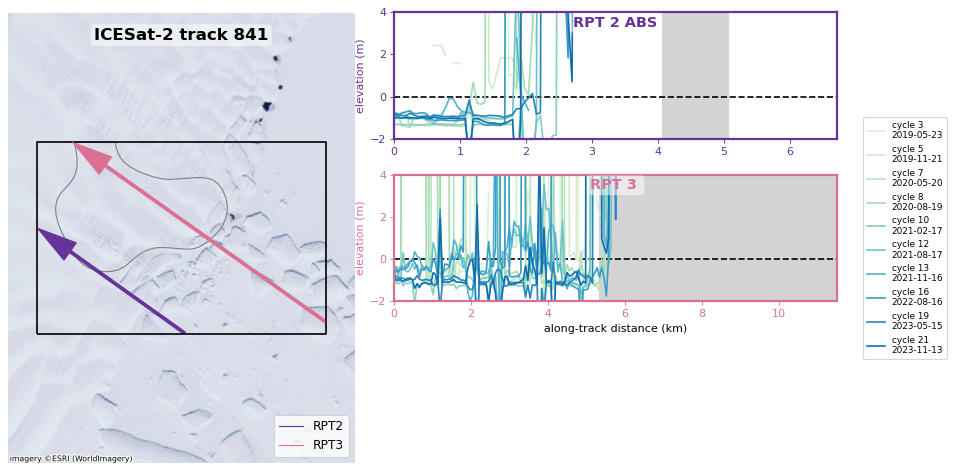

CPU times: user 628 ms, sys: 52.3 ms, total: 680 ms
Wall time: 685 ms


In [53]:
%%time
display(fig)

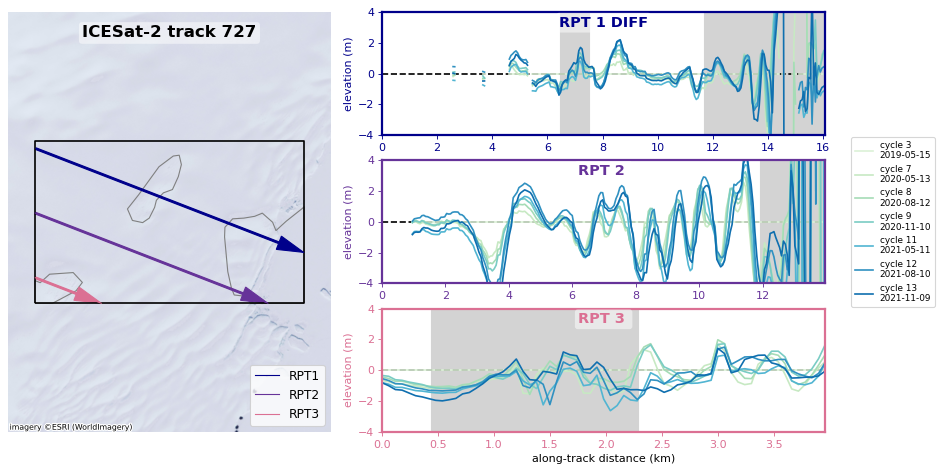

CPU times: user 1 s, sys: 54.2 ms, total: 1.06 s
Wall time: 1.08 s


In [602]:
%%time
display(fig)

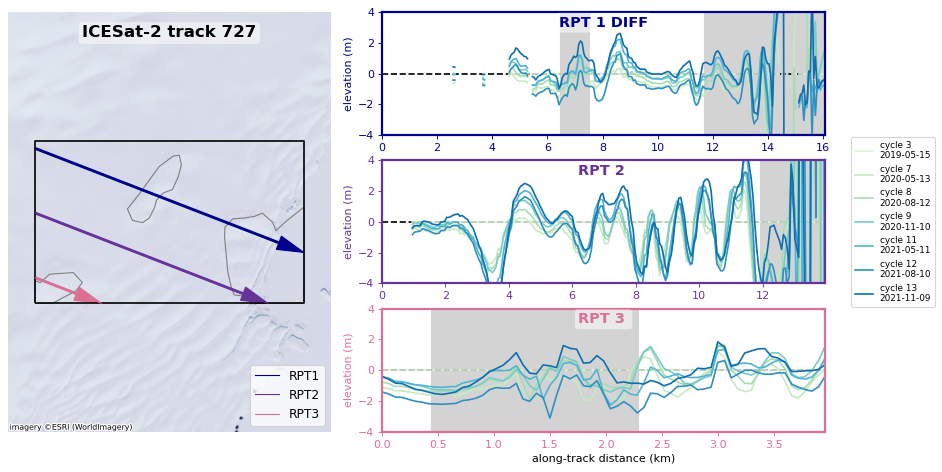

CPU times: user 1.04 s, sys: 42.8 ms, total: 1.09 s
Wall time: 1.11 s


In [600]:
%%time
display(fig)

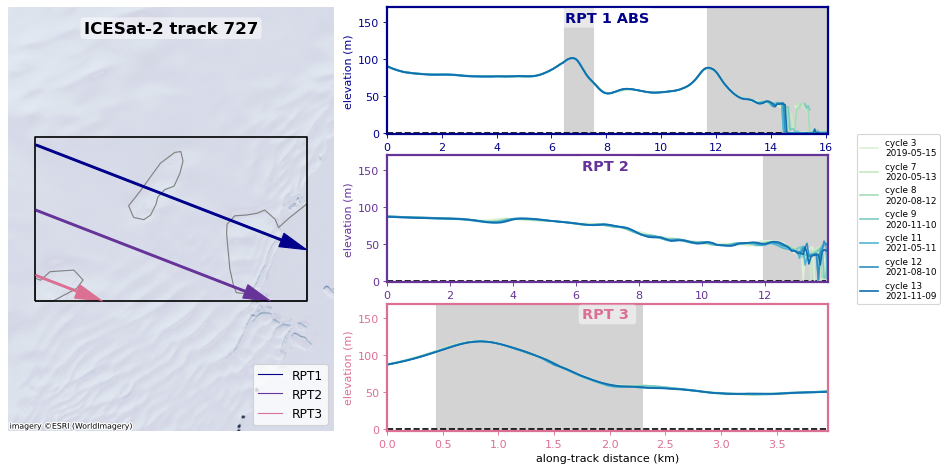

CPU times: user 983 ms, sys: 43.1 ms, total: 1.03 s
Wall time: 1.03 s


In [574]:
%%time
display(fig)

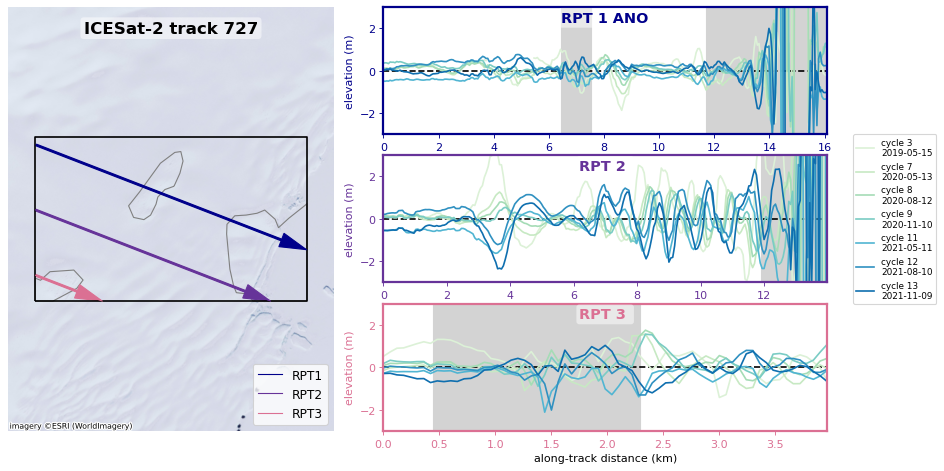

CPU times: user 1.02 s, sys: 53.3 ms, total: 1.07 s
Wall time: 1.09 s


In [472]:
%%time
display(fig)

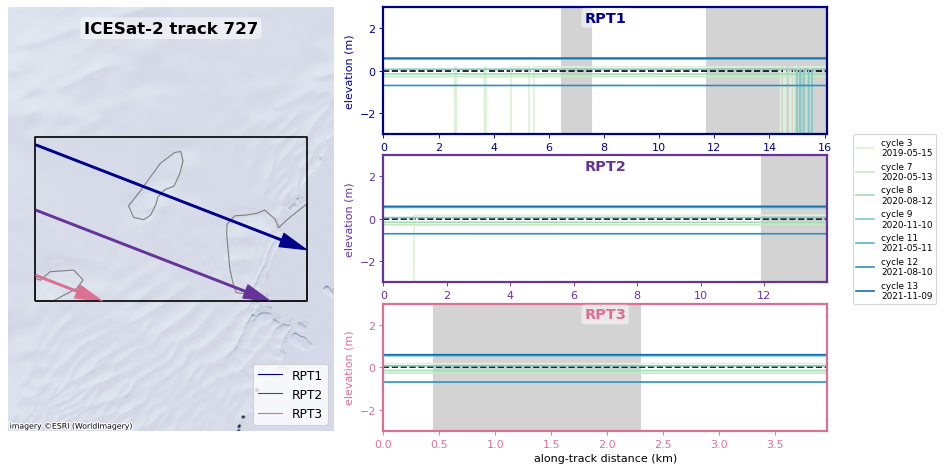

CPU times: user 898 ms, sys: 44 ms, total: 942 ms
Wall time: 960 ms


In [394]:
%%time
display(fig)

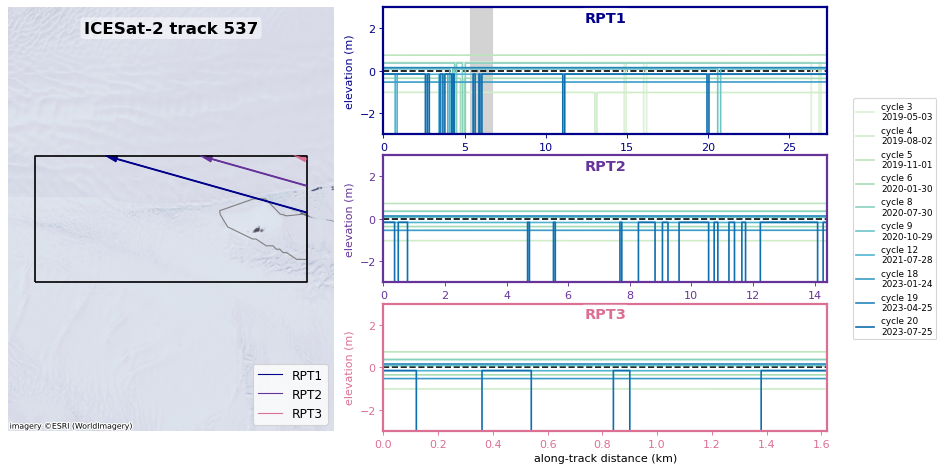

CPU times: user 995 ms, sys: 40.1 ms, total: 1.04 s
Wall time: 1.04 s


In [273]:
%%time
display(fig)

In [46]:
means = []
for cyc in ds.cycle_number[()]:
    mean = np.mean(ds.h_corr.sel(cycle_number=cyc))
    means.append(mean)
    

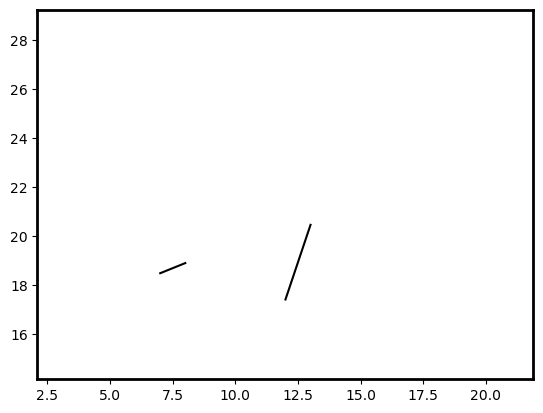

In [47]:
plt.figure()
plt.plot(ds.cycle_number[()], means, color='black')

In [ ]:
np.ma.zeros(

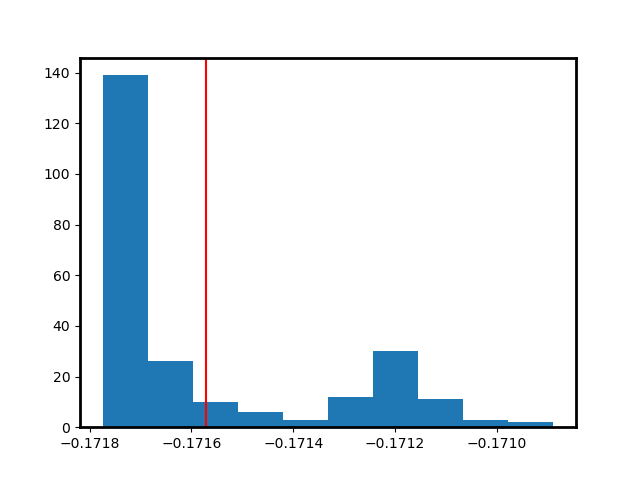

In [288]:
tide_arr = dst.tide_cats.sel(cycle_number=3)
plt.figure()
plt.hist(tide_arr[tide_arr<1e30])
plt.axvline(x=np.mean(tide_arr[tide_arr<1e30]), color='red')

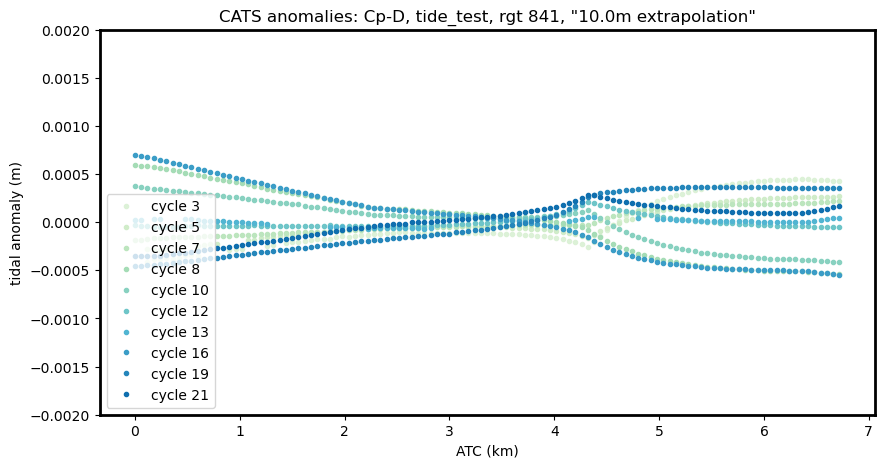

In [50]:
plt.figure(figsize=[10, 5])

for c in dfh_all.cycle_number:
    ds_red = ds.sel(cycle_number=c)
    tide_arr = ds_red.tide_cats[ds_red.tide_cats<1e30]
    lat_arr = ds_red.latitude[ds_red.tide_cats.data<1e30]
    atc_arr = ds_red.x_atc[ds_red.tide_cats<1e30]/1000
    color = dfh_all[dfh_all.cycle_number==c].color_chrono.iloc[0]
    plt.plot(atc_arr, tide_arr[tide_arr<1e30]-tide_arr[tide_arr<1e30].mean(), color=color, marker='.', linestyle='None', label=f'cycle {c}')
plt.title(f'CATS anomalies: {basin}, {region}, rgt {track}, \"10.0m extrapolation\"')
plt.legend()
plt.ylim([-0.002, 0.002])
plt.ylabel('tidal anomaly (m)')
plt.xlabel('ATC (km)')
plt.savefig('plots/tide_anoms_extrapolated.png', dpi=200, bbox_inches='tight')
    

In [ ]:
####################################################################################################################################
##### test zone ###

CPU times: user 675 ms, sys: 104 ms, total: 779 ms
Wall time: 794 ms


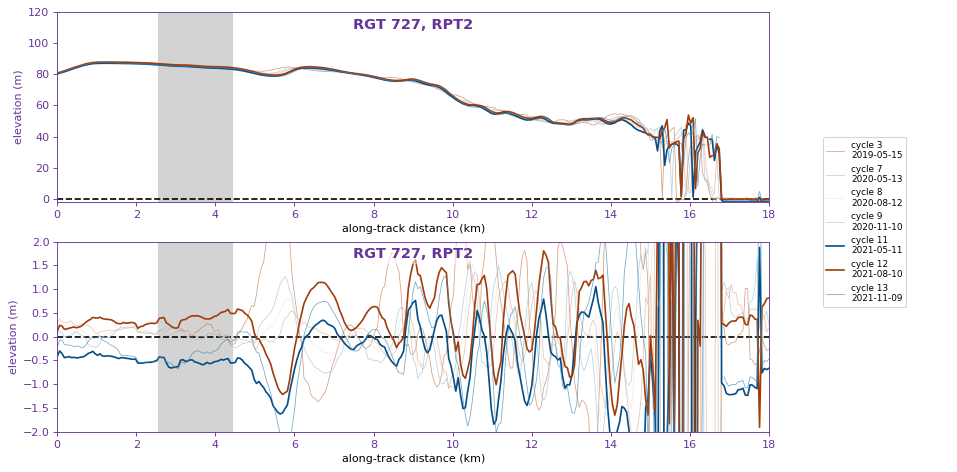

In [98]:
%%time
rpt = 2
plot_one(track, rpt, save=True)